In [18]:
import numpy as np
import time
import matplotlib.pyplot as plt 
from sklearn import linear_model

---

# Item XVI

Let $f(x) = \sum_{i=1}^n \alpha_i \text{sinc}(x-x_i)$ where $\text{sinc}(x) = \frac{\sin(x)}{x}$. Compute the total number of operations needed for evaluation of $f(x)$ at $x_j$, for $j=1 \dots n$. Also implement this algorithm and validate your estimation.

---

The first observation is that $\text{sinc}(x-x_i)$ should be defined as $\text{sinc}(0)=1$ when $x=x_i$. In this case, it's not necessary to compute one of the $\sin$'s nor the division.

So, for evaluating the function on a particular point $x$, the amount of $\sin$ that have to be calculated is $n$, but if $x=x_j$ for some $j$, then $n{-}1$ $\sin$ have to be calculated. The same goes for the amount of divisions by $x-x_j$, substractions to get $x-x_j$, multiplications by $a_j$ and $n-1$ sums to get the final amount.

| Operation | Times performed | Total ops. |
|:------| -----:| ---: |
| compute $x-x_j$  | $n$ | $n$ |
| compute $\sin(x-x_j)$ | $n-1$ | $(n-1)C$ |
| divide $\sin(x-x_j)$ by $x-x_j$ | $n-1$ | $n-1$ |
| multiply by $a_i$ | $n-1$ | $n-1$ |
| sum over $i$ | $n-1$ | $n-1$ |

This results in $4n-3+C(n-1)$ operations for each $f(x_j)$, if we compute add the operations required to compute all of them, we will end with $n(4n-3+C(n-1)) = O(n^2)$ where $C$ is the cost of computing a $\sin$.

Of course, additional optimizations could be done if some relations between the $x_j$ hold.

In [45]:
def sinc_sum(xs,alphas):
    n = len(xs)
    def loc_func(x):
        delta_xs = x-xs
        sinc = np.ones(n)
        sinc[delta_xs!=0] = np.sin(delta_xs[delta_xs!=0])/delta_xs[delta_xs!=0]
        return np.sum(alphas*sinc)
    return loc_func

In [48]:
N = np.logspace(1,4.4,num=30,dtype='int') # from 10 to ~25000
ts = []
for n in N:
    xsi = np.random.random(n)
    asi = np.random.random(n)
    f = sinc_sum(xsi,asi)
    start = time.time()
    f_evals = [f(x) for x in xsi]
    end = time.time()
    ts.append(end-start)
ts = np.array(ts)

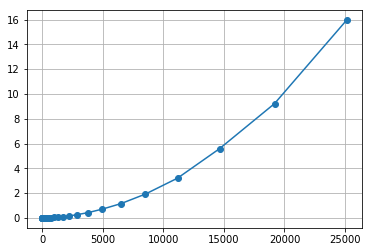

In [49]:
plt.plot(N,ts,'o-')
plt.grid(True)
plt.show()

We perform a linear regression with the last points, in logarithmic scale

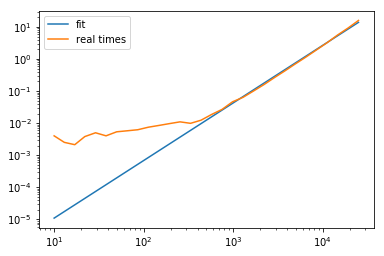

In [50]:
regr = linear_model.LinearRegression()
start = len(N)//2
logN = np.log(N.reshape((-1,1)))
logt = np.log(ts.reshape((-1,1)))
regr.fit(logN[start:],logt[start:])
# Check predictions:
res = np.exp(regr.predict(logN))
plt.loglog(N,res,label="fit")
plt.loglog(N,ts,label="real times")
plt.legend()

In [52]:
print("regr. coef     : %f"%regr.coef_)
print("regr. intercept: %f"%regr.intercept_)

regr. coef     : 1.794841
regr. intercept: -15.550982


We can see that the resulting fit was:

\begin{align}
\log(t) &= 1.794841 \log(n) -15.550982 \\
t &= e^{1.794841 \log(n) -15.550982} \\
t &= 1.76\cdot10^{-7} n^{1.794841} 
\end{align}

Which is somewhat near the $O(n^2)$ expected.